# Projet d'Analyse de Données — DatasetComp.xlsx

In [41]:

# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (8,5)
import pandas as pd
import numpy as np
from sklearn.model_selection   import train_test_split
from sklearn.preprocessing     import StandardScaler
from sklearn.compose           import ColumnTransformer
from sklearn.pipeline          import Pipeline
from sklearn.svm               import SVR
from sklearn.tree              import DecisionTreeRegressor
from sklearn.ensemble          import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics           import mean_squared_error, r2_score

# — 1) On part du DataFrame pivot créé précédemment —
# pivot = pd.read_excel(...).pivot_table(...)  # comme vu avant

# Pour rappel, pivot contient les colonnes :
# ['Region','RegAbbr','RegCode','Year','Rural','Total','Urban']

# — 2) Définir X (features) et y (target) —
# Ici, on choisit de prédire "Total" (pourcentage global),
# et d'utiliser Year, RegCode, Rural et Urban comme prédicteurs.
X = pivot[['Year', 'RegCode', 'Rural', 'Urban']]
y = pivot['Total']

# — 3) Split train / test —
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# — 4) Pré-processing des features numériques —
num_features = ['Year', 'RegCode']
preprocessor = ColumnTransformer([
    ('scale', StandardScaler(), num_features)
], remainder='passthrough')  # laisse 'Rural' et 'Urban' intactes

# — 5) Définition de nos modèles —
models = {
    'SVR (RBF)' : SVR(kernel='rbf', C=10, gamma='scale'),
    'Tree'      : DecisionTreeRegressor(max_depth=5, random_state=42),
    'RF'        : RandomForestRegressor(n_estimators=100, random_state=42),
    'XGB'       : xgb.XGBRegressor(n_estimators=100, random_state=42)
}

# — 6) Entraînement, prédiction et évaluation —
results = []
for name, model in models.items():
    pipe = Pipeline([
        ('prep',    preprocessor),
        ('model',   model)
    ])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2   = r2_score(y_test, y_pred)
    results.append({'Model': name, 'RMSE': rmse, 'R²': r2})

results_df = pd.DataFrame(results).set_index('Model')
print(results_df)



c:\Users\Adrien\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\Adrien\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\Adrien\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


           RMSE   R²
Model               
SVR (RBF)  3.67 0.90
Tree       3.51 0.91
RF         2.54 0.95
XGB        2.99 0.93


c:\Users\Adrien\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [3]:

df = pd.read_csv('datasetComp.csv', sep=';')



# -------------------------------------------
# 3. Exploratory Data Analysis (EDA)
# ------------------------------------------

In [4]:
# Vérification rapide de la structure
display("Dimensions :", df.shape)
display(df.dtypes)
display(df.head())

display(df.columns)

'Dimensions :'

(1848, 6)

Indicator      object
Year            int64
Region         object
Zone           object
Percentage     object
Real          float64
dtype: object

,Indicator,Year,Region,Zone,Percentage,Real
0,Population covered by a mobile-cellular networ...,2015,World,Rural,"88,9",NaN
1,Population covered by a mobile-cellular networ...,2015,Low-income,Rural,"67,1",NaN
2,Population covered by a mobile-cellular networ...,2015,Lower-middle-income,Rural,"90,1",NaN
3,Population covered by a mobile-cellular networ...,2015,Upper-middle-income,Rural,"91,2",NaN
4,Population covered by a mobile-cellular networ...,2015,High-income,Rural,"92,4",NaN


Index(['Indicator', 'Year', 'Region', 'Zone', 'Percentage', 'Real'], dtype='object')

In [5]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.2f}'.format)

Distribution des variables numériques:


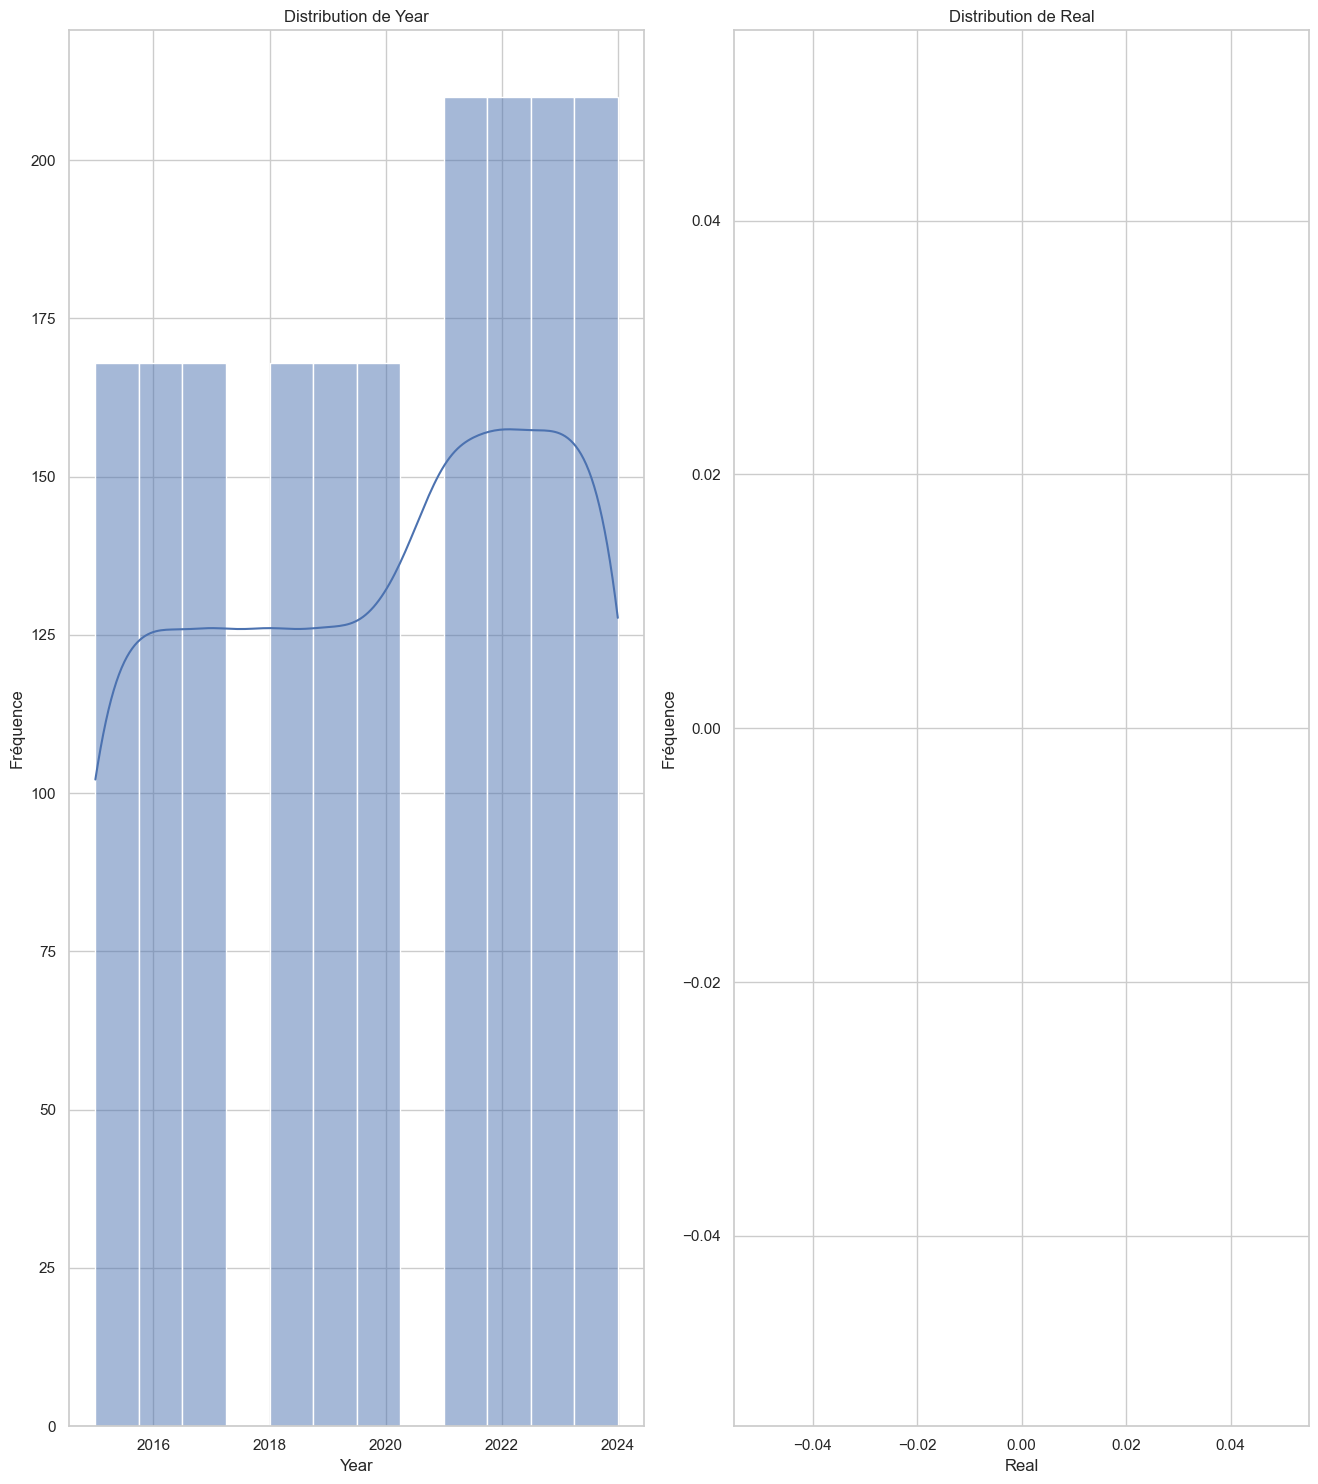

In [6]:
def plot_histograms(df, numerical_cols, n_cols=3, figsize=(20, 15)):
    n_rows = (len(numerical_cols) + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    axes = axes.flatten()
    
    for i, col in enumerate(numerical_cols):
        sns.histplot(df[col].dropna(), kde=True, ax=axes[i])
        axes[i].set_title(f'Distribution de {col}', fontsize=12)
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Fréquence')
    
    # Masquer les axes supplémentaires si nécessaire
    for j in range(i+1, len(axes)):
        axes[j].set_visible(False)
    
    plt.tight_layout()
    plt.show()

numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Tracé des histogrammes
print("Distribution des variables numériques:")
plot_histograms(df, numerical_cols)


In [7]:
def clean_numeric(value):
    if isinstance(value, str):
        return float(value.replace(',', '.'))
    return value


# Affichage des premières lignes pour vérification
print("Aperçu des données :")
display(df.head())

# ### 2.2 Analyse préliminaire des données

# Informations générales sur le dataset
print("\nInformations sur le dataset :")
display(df.info())

# Description statistique des données numériques
print("\nStatistiques descriptives :")
display(df.describe())



Aperçu des données :


,Indicator,Year,Region,Zone,Percentage,Real
0,Population covered by a mobile-cellular networ...,2015,World,Rural,"88,9",NaN
1,Population covered by a mobile-cellular networ...,2015,Low-income,Rural,"67,1",NaN
2,Population covered by a mobile-cellular networ...,2015,Lower-middle-income,Rural,"90,1",NaN
3,Population covered by a mobile-cellular networ...,2015,Upper-middle-income,Rural,"91,2",NaN
4,Population covered by a mobile-cellular networ...,2015,High-income,Rural,"92,4",NaN



Informations sur le dataset :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1848 entries, 0 to 1847
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Indicator   1848 non-null   object 
 1   Year        1848 non-null   int64  
 2   Region      1848 non-null   object 
 3   Zone        1848 non-null   object 
 4   Percentage  1848 non-null   object 
 5   Real        0 non-null      float64
dtypes: float64(1), int64(1), object(4)
memory usage: 86.8+ KB


None


Statistiques descriptives :


,Year,Real
count,1848.00,0.00
mean,2019.77,NaN
std,2.89,NaN
min,2015.00,NaN
25%,2017.00,NaN
50%,2020.00,NaN
75%,2022.00,NaN
max,2024.00,NaN


In [8]:
def clean_numeric(value):
	if isinstance(value, str):
		value = value.strip()
		if value.lower() in ['n/a', 'na', ' n/a ']:
			return np.nan
		try:
			return float(value.replace(',', '.'))
		except ValueError:
			return np.nan
	return value

df['Percentage'] = df['Percentage'].apply(clean_numeric)

In [9]:
display(df['Percentage'].head())
print("\nValeurs manquantes par colonne :")
display(df.isnull().sum())
# 2. Valeurs manquantes
print(f"Pourcentage de NA : {round(df.isna().sum().sum() / df.size * 100, 1)}%")

0   88.90
1   67.10
2   90.10
3   91.20
4   92.40
Name: Percentage, dtype: float64


Valeurs manquantes par colonne :


Indicator        0
Year             0
Region           0
Zone             0
Percentage     241
Real          1848
dtype: int64

Pourcentage de NA : 18.8%


In [10]:
# doublons
print(f"Doublons : {df.duplicated().sum()}")

Doublons : 0


In [11]:
# 2.3 Traitement des valeurs manquantes dans la colonne 'Percentage'

# Vérification des valeurs manquantes avant le remplacement
null_values_before = df.isnull().sum()
n_missing_before = df['Percentage'].isnull().sum()
print(f"Nombre de valeurs manquantes dans 'Percentage' avant traitement: {n_missing_before}")

# Calcul des moyennes par Indicateur et Année
indicator_year_means = df.groupby(['Indicator', 'Year'])['Percentage'].transform('mean')



Nombre de valeurs manquantes dans 'Percentage' avant traitement: 241


In [12]:
# Remplacement des valeurs manquantes par la moyenne de l'indicateur et de l'année correspondante
df['Percentage'].fillna(indicator_year_means, inplace=True)

# Si des valeurs restent manquantes (ex: si l'indicateur entier pour une année n'a pas de valeur),
# les remplacer par la moyenne globale
mean_value = df['Percentage'].mean()
df['Percentage'].fillna(mean_value, inplace=True)

# Vérification après remplacement
null_values_after = df.isnull().sum()
n_missing_after = df['Percentage'].isnull().sum()
print(f"Nombre de valeurs manquantes dans 'Percentage' après traitement: {n_missing_after}")
print(f"Moyenne globale utilisée pour les remplacements restants: {mean_value:.2f}")

# tableau pivot pour visualiser les données par région, zone et indicateur
pivot_df = df.pivot_table(index=['Region', 'Zone', 'Indicator'], 
                         columns='Year', 
                         values='Percentage')

# aperçu du tableau pivot
print("\nTableau pivot des pourcentages par région, zone et indicateur:")
display(pivot_df.head())



Nombre de valeurs manquantes dans 'Percentage' après traitement: 0
Moyenne globale utilisée pour les remplacements restants: 72.78

Tableau pivot des pourcentages par région, zone et indicateur:


C:\Users\Adrien\AppData\Local\Temp\ipykernel_10264\1355934818.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Percentage'].fillna(indicator_year_means, inplace=True)
C:\Users\Adrien\AppData\Local\Temp\ipykernel_10264\1355934818.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a c

Year                                                                2015  \
Region    Zone  Indicator                                                  
Africa    Rural Population covered by at least a 3G mobile netw... 29.70   
          Total Population covered by at least a 3G mobile netw... 49.60   
          Urban Population covered by at least a 3G mobile netw... 86.10   
Americas  Rural Population covered by at least a 3G mobile netw... 65.10   
          Total Population covered by at least a 3G mobile netw... 91.40   

Year                                                                2016  \
Region    Zone  Indicator                                                  
Africa    Rural Population covered by at least a 3G mobile netw... 37.40   
          Total Population covered by at least a 3G mobile netw... 57.50   
          Urban Population covered by at least a 3G mobile netw... 92.80   
Americas  Rural Population covered by at least a 3G mobile netw... 69.50   
          Total Population covered by at least a 3G mobile netw... 92.80   

Year                                                                2017  \
Region    Zone  Indicator                                                  
Africa    Rural Population covered by at least a 3G mobile netw... 42.00   
          Total Population covered by at least a 3G mobile netw... 62.60   
          Urban Population covered by at least a 3G mobile netw... 94.10   
Americas  Rural Population covered by at least a 3G mobile netw... 72.00   
          Total Population covered by at least a 3G mobile netw... 94.00   

Year                                                                2018  \
Region    Zone  Indicator                                                  
Africa    Rural Population covered by at least a 3G mobile netw... 53.10   
          Total Population covered by at least a 3G mobile netw... 70.30   
          Urban Population covered by at least a 3G mobile netw... 95.60   
Americas  Rural Population covered by at least a 3G mobile netw... 72.50   
          Total Population covered by at least a 3G mobile netw... 94.70   

Year                                                                2019  \
Region    Zone  Indicator                                                  
Africa    Rural Population covered by at least a 3G mobile netw... 59.10   
          Total Population covered by at least a 3G mobile netw... 73.70   
          Urban Population covered by at least a 3G mobile netw... 96.90   
Americas  Rural Population covered by at least a 3G mobile netw... 73.00   
          Total Population covered by at least a 3G mobile netw... 94.50   

Year                                                                2020  \
Region    Zone  Indicator                                                  
Africa    Rural Population covered by at least a 3G mobile netw... 59.20   
          Total Population covered by at least a 3G mobile netw... 75.90   
          Urban Population covered by at least a 3G mobile netw... 99.40   
Americas  Rural Population covered by at least a 3G mobile netw... 72.20   
          Total Population covered by at least a 3G mobile netw... 94.60   

Year                                                                2021  \
Region    Zone  Indicator                                                  
Africa    Rural Population covered by at least a 3G mobile netw... 64.20   
          Total Population covered by at least a 3G mobile netw... 79.10   
          Urban Population covered by at least a 3G mobile netw... 99.80   
Americas  Rural Population covered by at least a 3G mobile netw... 72.20   
          Total Population covered by at least a 3G mobile netw... 94.70   

Year                                                                2022  \
Region    Zone  Indicator                                                  
Africa    Rural Population covered by at least a 3G mobile netw... 68.50   
          Total Population covered by at 

In [13]:
# les valeurs uniques de la colonne "Indicator" pour etre sur de tout avoir
print("Valeurs uniques dans la colonne Indicator:")
display(df['Indicator'].unique())

# Pour pour voir aussi le nombre d'occurrences de chaque valeur
print("\nRépartition des valeurs dans Indicator:")
display(df['Indicator'].value_counts())

# Pour connaître simplement le nombre de valeurs uniques
print(f"\nNombre de valeurs uniques dans Indicator: {df['Indicator'].nunique()}")

Valeurs uniques dans la colonne Indicator:


array(['Population covered by a mobile-cellular network (%)',
       'Population covered by at least a 3G mobile network (%)',
       'Population covered by at least an LTE/WiMAX mobile network',
       'Population covered by at least a 5G mobile network (%)',
       'Percentage of individuals using the Internet, by urban/rural area'],
      dtype=object)


Répartition des valeurs dans Indicator:


Indicator
Population covered by a mobile-cellular network (%)                  420
Population covered by at least a 3G mobile network (%)               420
Population covered by at least an LTE/WiMAX mobile network           420
Population covered by at least a 5G mobile network (%)               420
Percentage of individuals using the Internet, by urban/rural area    168
Name: count, dtype: int64


Nombre de valeurs uniques dans Indicator: 5


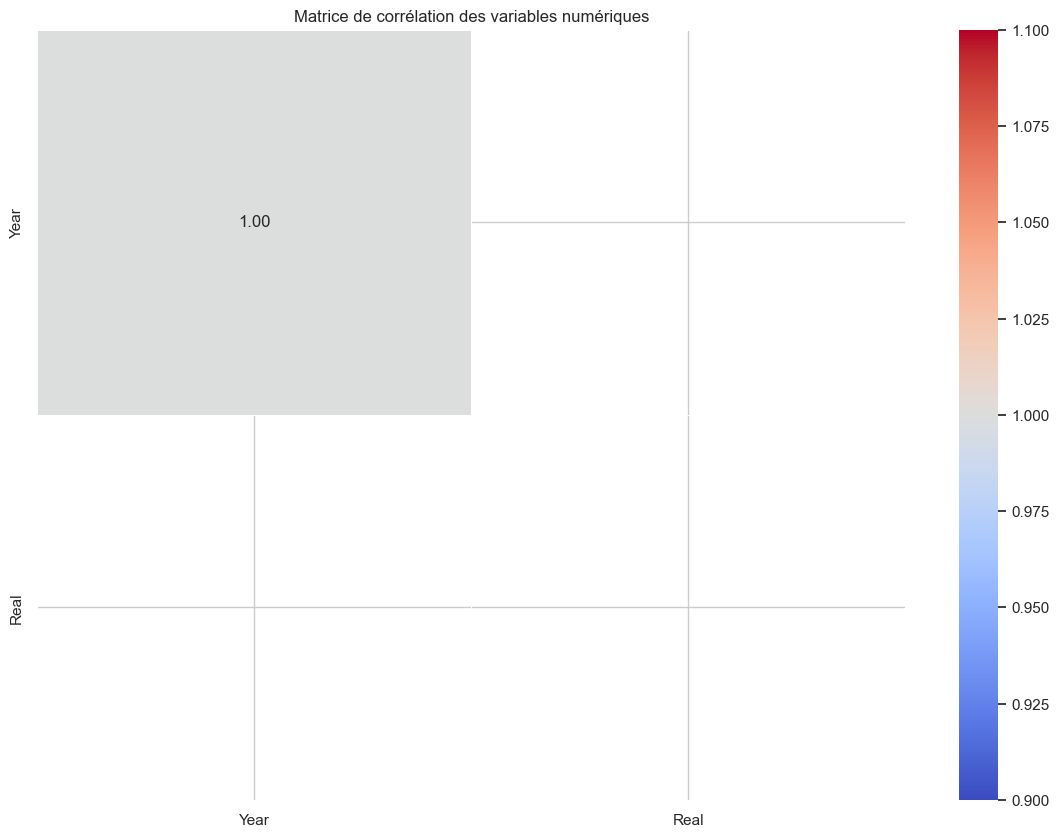

In [14]:
# Matrice de corrélation
plt.figure(figsize=(14, 10))
correlation_matrix = df[numerical_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Matrice de corrélation des variables numériques')
plt.show()

count   1848.00
mean      72.78
std       28.65
min        0.10
25%       61.60
50%       81.00
75%       96.60
max      100.00
Name: Percentage, dtype: float64


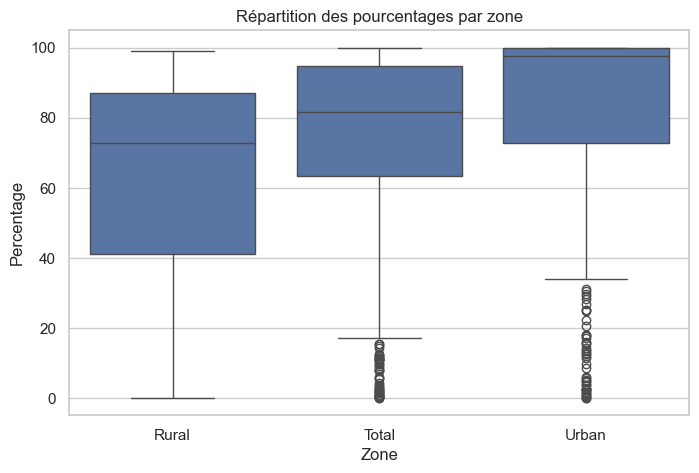

In [15]:
#Statistiques sur Percentage
print(df["Percentage"].describe())
sns.boxplot(x="Zone", y="Percentage", data=df)
plt.title("Répartition des pourcentages par zone"); plt.show()

Analyse du boxplot
- Le boxplot montre la répartition des pourcentages par indicateur pour chaque zone.
- Les zones sont représentées sur l'axe des abscisses (x), et les pourcentages sur l'axe des ordonnées (y).

Points clés à observer :
1. Médiane : La ligne à l'intérieur de chaque boîte représente la médiane des données pour cet indicateur dans la zone donnée.
2. Quartiles : Les limites de la boîte représentent le premier quartile (Q1) et le troisième quartile (Q3).
3. Étendue interquartile (IQR) : La hauteur de la boîte montre l'IQR, qui est Q3 - Q1.
4. Outliers : Les points situés en dehors des "moustaches" (whiskers) sont des valeurs aberrantes.

 Interprétation :
 - Une boîte plus petite indique une faible variabilité des données pour cet indicateur dans la zone.
 - Une boîte plus grande indique une plus grande variabilité.
 - Les outliers peuvent indiquer des valeurs extrêmes ou des anomalies dans les données.
 - Comparer les boîtes entre les zones permet d'identifier les différences dans la répartition des pourcentages pour chaque indicateur.

observation :
On conctate clairement que le pourcentage global de couverture mobile etc est plus élevé pour la zone URBAN

**Création des boxplots par zone et par indicateur**

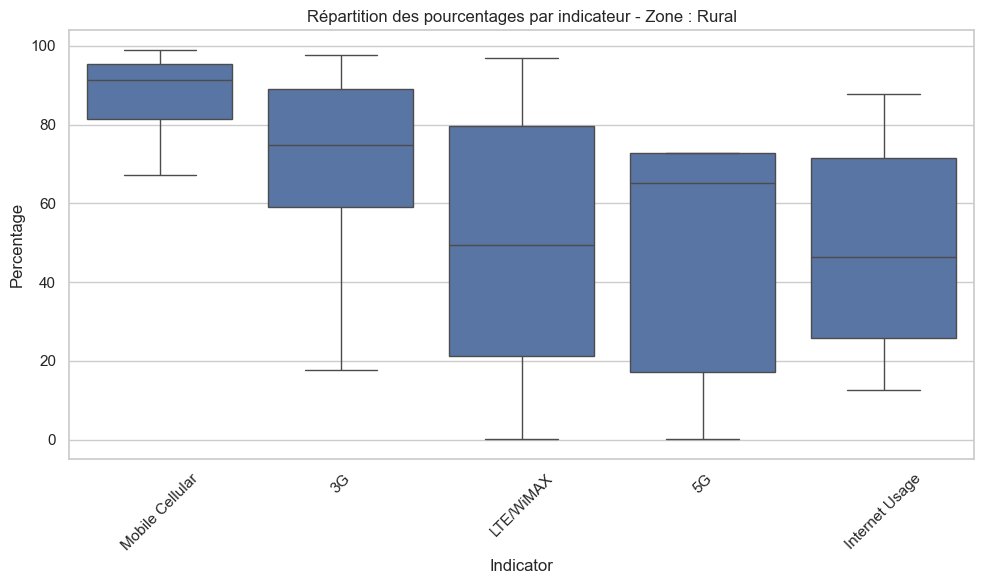

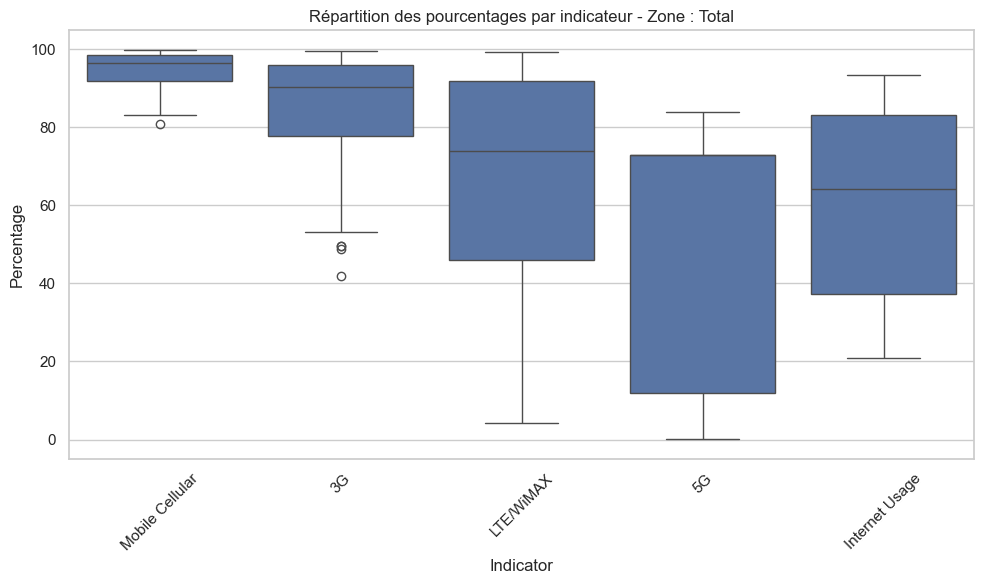

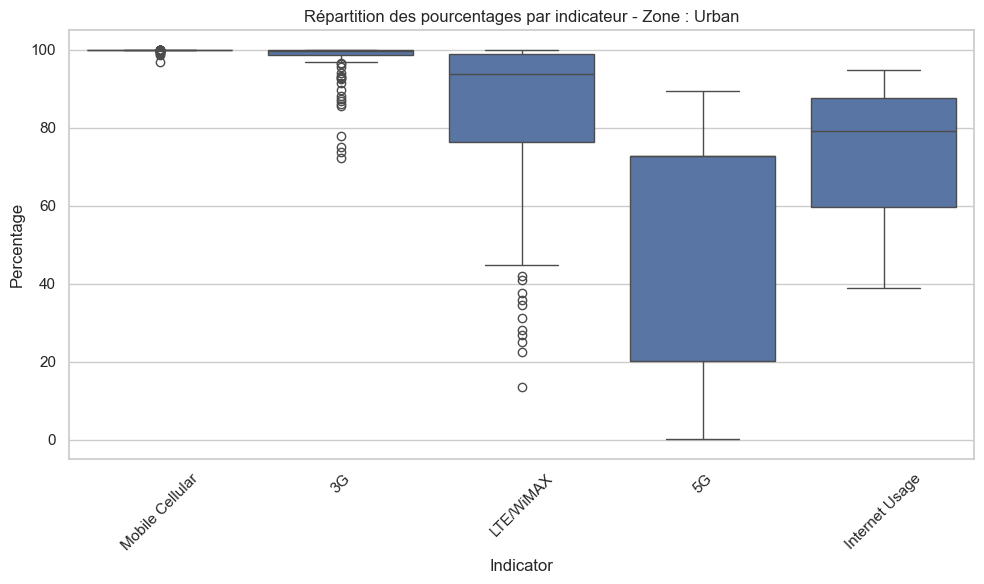

In [16]:
# renommage des indicateurs
renommage = {
    "Population covered by at least a 3G mobile network (%)": "3G",
    "Population covered by a mobile-cellular network (%)": "Mobile Cellular",
    "Population covered by at least an LTE/WiMAX mobile network": "LTE/WiMAX",
    "Percentage of individuals using the Internet, by urban/rural area": "Internet Usage",
    "Population covered by at least a 5G mobile network (%)": "5G"
}

df["Indicator"] = df["Indicator"].replace(renommage)

# boxplots par zone et par indicateur
zones = df["Zone"].unique()
for zone in zones:
    plt.figure(figsize=(10, 6))
    sns.boxplot(
        data=df[df["Zone"] == zone],
        x="Indicator",
        y="Percentage"
    )
    plt.title(f"Répartition des pourcentages par indicateur - Zone : {zone}")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

**On va donc supprimer les valeurs aberrantes**


=== Traitement des outliers pour le pourcentage ===
Traitement des outliers pour 15 groupes (combinaisons de Zone et Indicator)...

Statistiques des outliers par groupe:


,Zone,Indicator,Outliers Count,Outliers Percentage
2,Urban,Mobile Cellular,31,22.14
4,Urban,3G,19,13.57
7,Urban,LTE/WiMAX,11,7.86
3,Total,3G,4,2.86
1,Total,Mobile Cellular,1,0.71
0,Rural,Mobile Cellular,0,0.00
5,Rural,3G,0,0.00
6,Total,LTE/WiMAX,0,0.00
8,Rural,LTE/WiMAX,0,0.00
9,Rural,5G,0,0.00


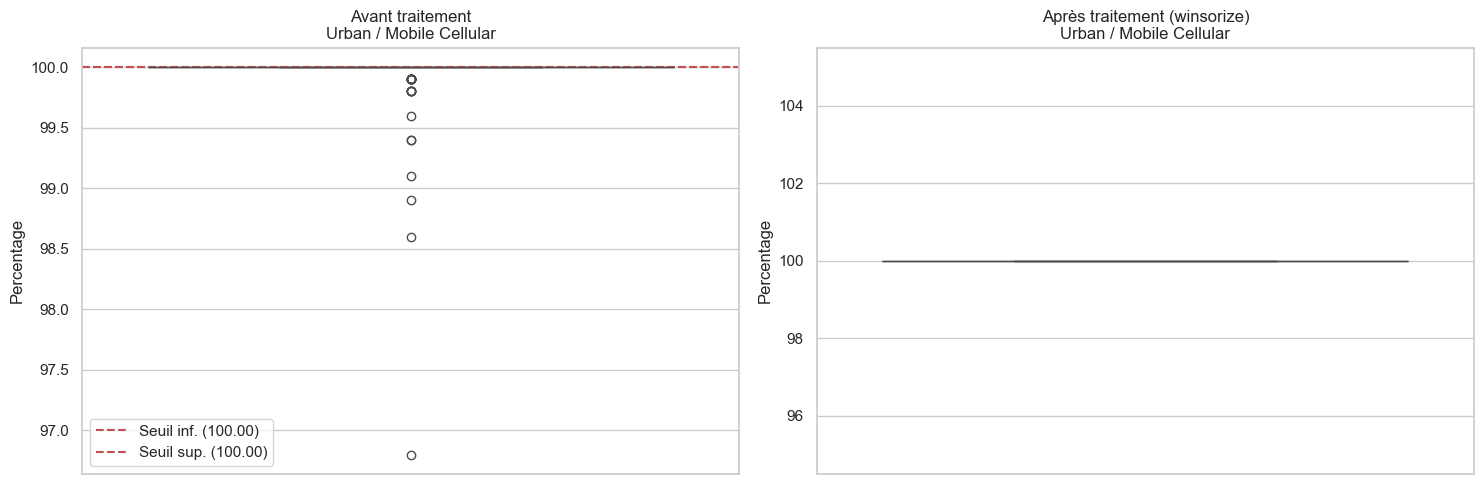

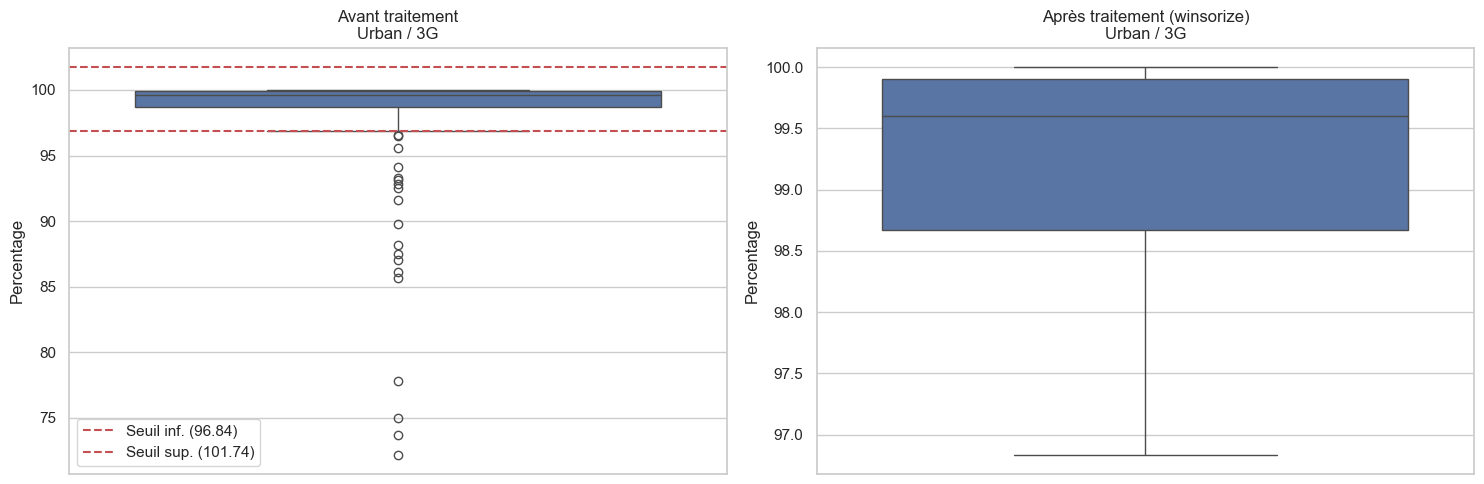

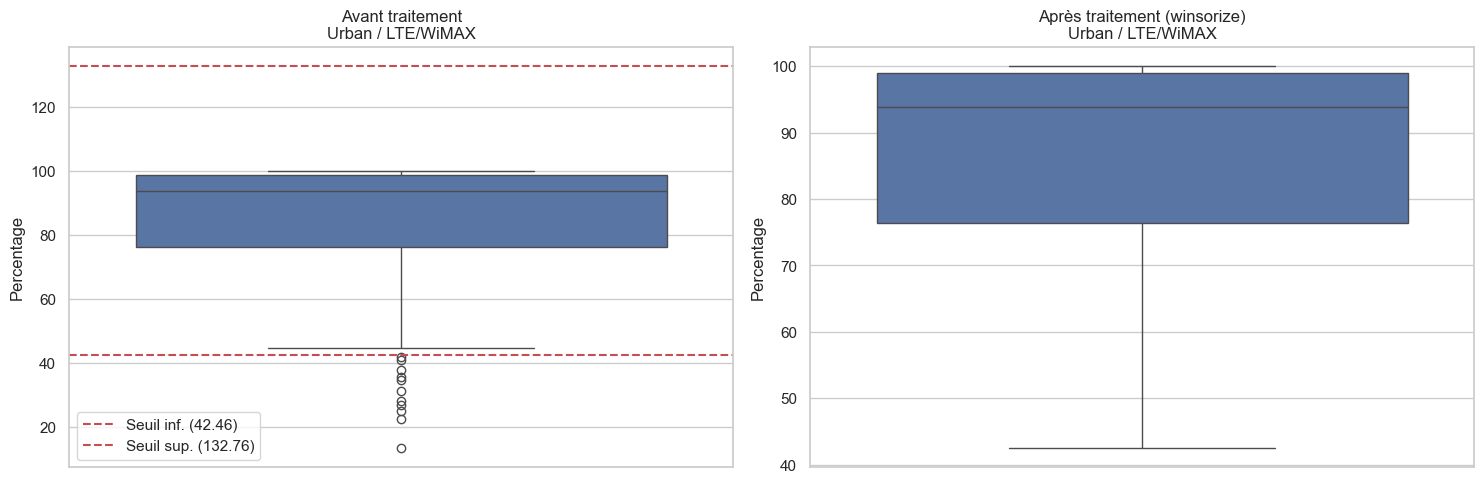

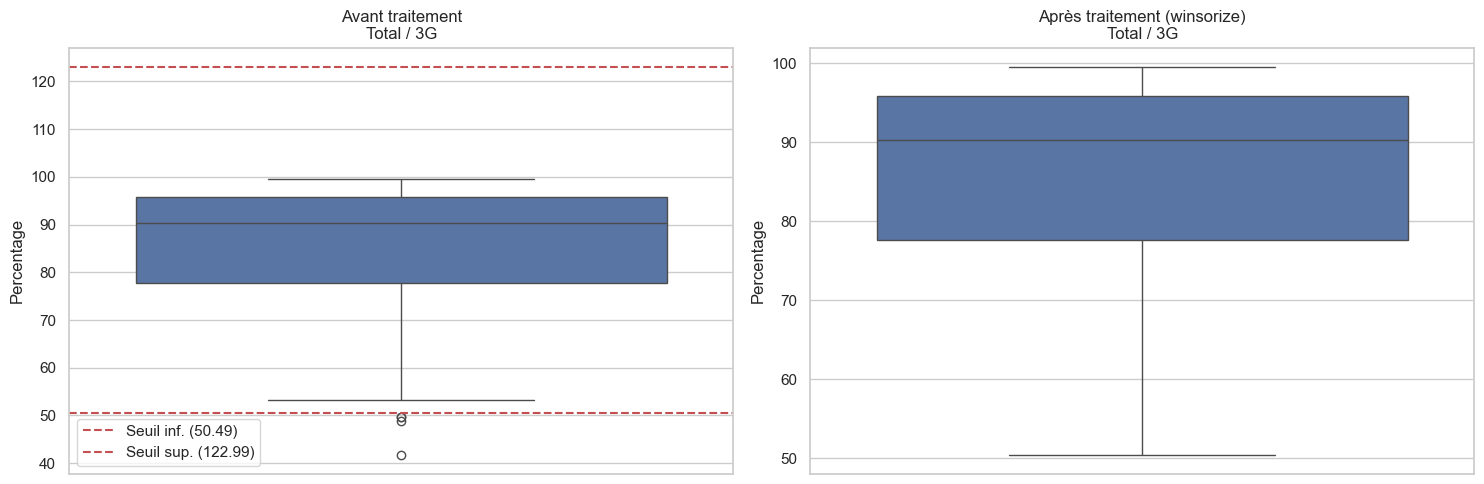

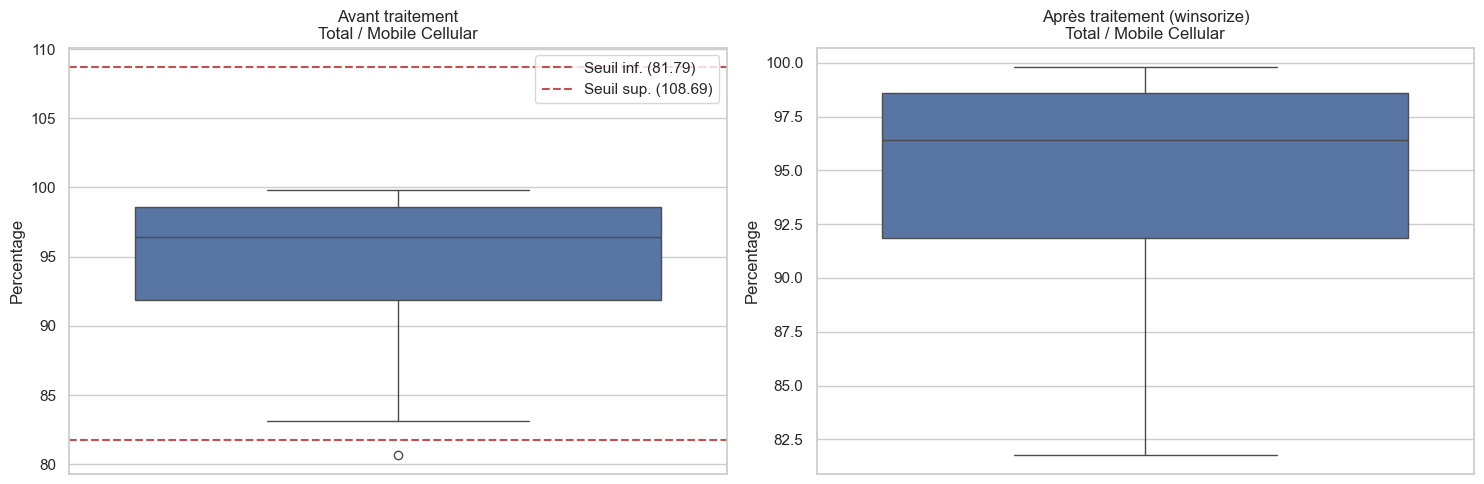

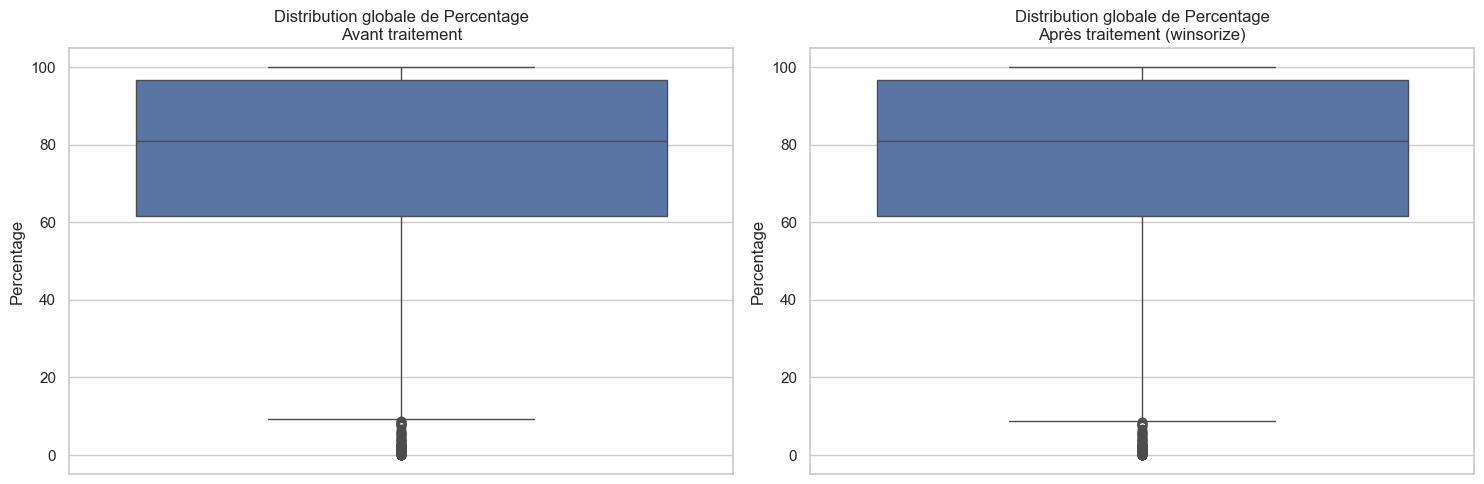

C:\Users\Adrien\AppData\Local\Temp\ipykernel_10264\3589194590.py:182: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45, ha='right')
C:\Users\Adrien\AppData\Local\Temp\ipykernel_10264\3589194590.py:187: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45, ha='right')


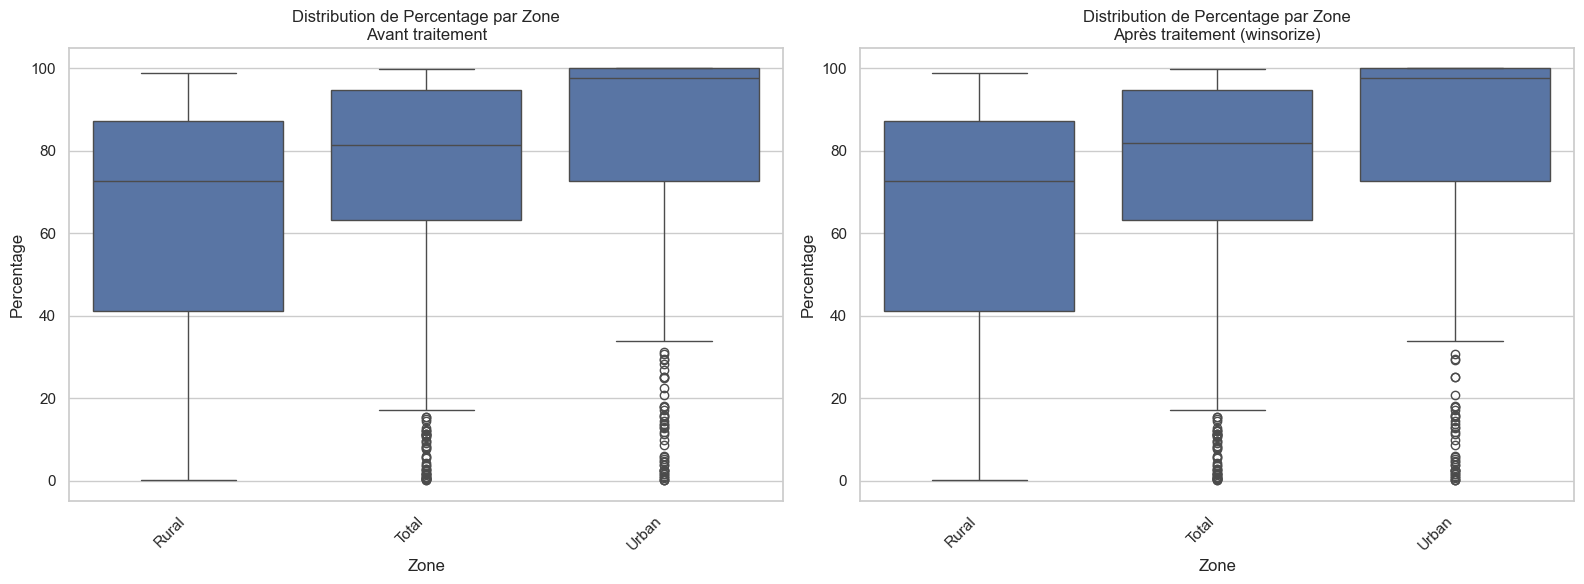


Résumé de l'impact du traitement des outliers (winsorize):
- Nombre total d'outliers identifiés: 66
- Nombre de valeurs remplacées par les bornes: 66

Statistiques descriptives avant traitement:


count   1848.00
mean      72.78
std       28.65
min        0.10
25%       61.60
50%       81.00
75%       96.60
max      100.00
Name: Percentage, dtype: float64


Statistiques descriptives après traitement:


count   1848.00
mean      72.96
std       28.61
min        0.10
25%       61.60
50%       81.05
75%       96.84
max      100.00
Name: Percentage, dtype: float64

In [ ]:
def handle_and_visualize_outliers(df, percentage_col, zone_col='ZONE', indicator_col='INDICATOR', 
                                method='winsorize', threshold=1.5, max_groups_display=6):
    """
    Détecte, traite et visualise les valeurs aberrantes séparément pour chaque combinaison 
    de zone et d'indicateur.
    
    Paramètres:
    -----------
    df : DataFrame
        Le DataFrame contenant les données
    percentage_col : str
        Nom de la colonne contenant les valeurs en pourcentage à analyser
    zone_col : str
        Nom de la colonne contenant les différentes zones
    indicator_col : str
        Nom de la colonne contenant les différents indicateurs
    method : str, {'winsorize', 'remove', 'replace_nan'}
        Méthode de traitement des outliers
    threshold : float
        Facteur multiplicatif pour l'IQR pour définir les bornes
    max_groups_display : int
        Nombre maximum de groupes à afficher dans les visualisations
        
    Returns:
    --------
    DataFrame: Le DataFrame avec les outliers traités
    """
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    from matplotlib.gridspec import GridSpec
    
    df_clean = df.copy()
    
    # Liste pour stocker les indices des lignes à supprimer si method=='remove'
    indices_to_drop = []
    
    # Dictionnaire pour stocker les statistiques sur les outliers
    outliers_stats = {}
    
    # Récupérer toutes les combinaisons uniques de zone et d'indicateur
    groups = df[[zone_col, indicator_col]].drop_duplicates()
    
    print(f"Traitement des outliers pour {len(groups)} groupes (combinaisons de {zone_col} et {indicator_col})...")
    
    # Pour chaque combinaison, détecter et traiter les outliers
    for _, group in groups.iterrows():
        zone = group[zone_col]
        indicator = group[indicator_col]
        
        # Créer un masque pour filtrer les données du groupe
        mask = (df[zone_col] == zone) & (df[indicator_col] == indicator)
        
        # Obtenir les valeurs pour ce groupe
        values = df.loc[mask, percentage_col]
        
        # Si moins de 4 points de données, on ne peut pas détecter d'outliers significativement
        if len(values) < 4:
            outliers_stats[(zone, indicator)] = {'count': 0, 'percentage': 0}
            continue
        
        # Calcul des statistiques pour ce groupe
        Q1 = values.quantile(0.25)
        Q3 = values.quantile(0.75)
        IQR = Q3 - Q1
        
        # Définir les bornes pour les outliers
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR
        
        # Identifier les outliers pour ce groupe
        outliers_mask = (values < lower_bound) | (values > upper_bound)
        outliers_indices = values[outliers_mask].index
        outliers_count = len(outliers_indices)
        outliers_percentage = (outliers_count / len(values)) * 100 if len(values) > 0 else 0
        
        # Stocker les statistiques
        outliers_stats[(zone, indicator)] = {
            'count': outliers_count,
            'percentage': outliers_percentage,
            'lower_bound': lower_bound,
            'upper_bound': upper_bound
        }
        
        if outliers_count > 0:
            if method == 'winsorize':
                # Remplacer les outliers par les bornes
                df_clean.loc[outliers_indices[values[outliers_indices] < lower_bound], percentage_col] = lower_bound
                df_clean.loc[outliers_indices[values[outliers_indices] > upper_bound], percentage_col] = upper_bound
                
            elif method == 'remove':
                # Stocker les indices pour suppression
                indices_to_drop.extend(outliers_indices)
                
            elif method == 'replace_nan':
                # Remplacer par NaN
                df_clean.loc[outliers_indices, percentage_col] = np.nan
    
    # Si la méthode est 'remove', supprimer toutes les lignes identifiées
    if method == 'remove':
        df_clean = df_clean.drop(indices_to_drop)
        print(f"  Total: {len(indices_to_drop)} lignes avec outliers supprimées.")
    
    # Convertir les statistiques en DataFrame pour faciliter l'affichage
    stats_df = pd.DataFrame([
        {
            'Zone': zone,
            'Indicator': indicator,
            'Outliers Count': stats['count'],
            'Outliers Percentage': stats['percentage']
        }
        for (zone, indicator), stats in outliers_stats.items()
    ])
    
    # Trier par nombre d'outliers (ordre décroissant)
    stats_df = stats_df.sort_values('Outliers Count', ascending=False)
    
    print("\nStatistiques des outliers par groupe:")
    display(stats_df.head(10))  # Afficher les 10 premiers groupes avec le plus d'outliers
    
    # Sélectionner les groupes avec le plus d'outliers pour visualisation
    top_groups = stats_df.head(max_groups_display)
    
    # Visualiser les boxplots avant et après traitement pour les groupes sélectionnés
    for idx, row in top_groups.iterrows():
        zone = row['Zone']
        indicator = row['Indicator']
        
        if row['Outliers Count'] == 0:
            continue  # Skip groups without outliers
            
        # Filtrer les données pour ce groupe
        mask_before = (df[zone_col] == zone) & (df[indicator_col] == indicator)
        mask_after = (df_clean[zone_col] == zone) & (df_clean[indicator_col] == indicator)
        
        # Créer un subplot avec deux boxplots côte à côte
        fig, ax = plt.subplots(1, 2, figsize=(15, 5))
        
        # Boxplot avant traitement
        sns.boxplot(y=df.loc[mask_before, percentage_col], ax=ax[0])
        ax[0].set_title(f'Avant traitement\n{zone} / {indicator}')
        ax[0].set_ylabel(percentage_col)
        
        # Ajouter les limites des outliers
        if 'lower_bound' in outliers_stats[(zone, indicator)]:
            ax[0].axhline(y=outliers_stats[(zone, indicator)]['lower_bound'], color='r', linestyle='--', 
                         label=f"Seuil inf. ({outliers_stats[(zone, indicator)]['lower_bound']:.2f})")
            ax[0].axhline(y=outliers_stats[(zone, indicator)]['upper_bound'], color='r', linestyle='--', 
                         label=f"Seuil sup. ({outliers_stats[(zone, indicator)]['upper_bound']:.2f})")
            ax[0].legend()
        
        # Boxplot après traitement
        sns.boxplot(y=df_clean.loc[mask_after, percentage_col], ax=ax[1])
        ax[1].set_title(f'Après traitement ({method})\n{zone} / {indicator}')
        ax[1].set_ylabel(percentage_col)
        
        plt.tight_layout()
        plt.show()
    
    # Visualisation des distributions globales avant et après traitement
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    
    # Distribution avant traitement
    sns.boxplot(y=df[percentage_col], ax=ax[0])
    ax[0].set_title(f'Distribution globale de {percentage_col}\nAvant traitement')
    
    # Distribution après traitement
    sns.boxplot(y=df_clean[percentage_col], ax=ax[1])
    ax[1].set_title(f'Distribution globale de {percentage_col}\nAprès traitement ({method})')
    
    plt.tight_layout()
    plt.show()
    
    # Créer une vue agrégée par zone pour une visualisation plus claire
    if len(df[zone_col].unique()) <= 10:  # Si le nombre de zones est raisonnable
        fig, ax = plt.subplots(1, 2, figsize=(16, 6))
        
        # Boxplot par zone avant traitement
        sns.boxplot(x=zone_col, y=percentage_col, data=df, ax=ax[0])
        ax[0].set_title(f'Distribution de {percentage_col} par {zone_col}\nAvant traitement')
        ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45, ha='right')
        
        # Boxplot par zone après traitement
        sns.boxplot(x=zone_col, y=percentage_col, data=df_clean, ax=ax[1])
        ax[1].set_title(f'Distribution de {percentage_col} par {zone_col}\nAprès traitement ({method})')
        ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45, ha='right')
        
        plt.tight_layout()
        plt.show()
    
    # Résumé de l'impact du traitement
    print(f"\nRésumé de l'impact du traitement des outliers ({method}):")
    print(f"- Nombre total d'outliers identifiés: {sum(stats['count'] for stats in outliers_stats.values())}")
    if method == 'remove':
        print(f"- Nombre de lignes supprimées: {len(indices_to_drop)}")
    elif method == 'winsorize':
        print(f"- Nombre de valeurs remplacées par les bornes: {sum(stats['count'] for stats in outliers_stats.values())}")
    elif method == 'replace_nan':
        print(f"- Nombre de valeurs remplacées par NaN: {sum(stats['count'] for stats in outliers_stats.values())}")
    
    # Comparaison des statistiques descriptives avant et après traitement
    print("\nStatistiques descriptives avant traitement:")
    display(df[percentage_col].describe())
    
    print("\nStatistiques descriptives après traitement:")
    display(df_clean[percentage_col].describe())
    
    return df_clean

# Exemple d'utilisation:
# Pour chaque colonne de pourcentage dans votre dataset
"""
percentage_columns = ['Percentage_Column1', 'Percentage_Column2']

for col in percentage_columns:
    print(f"\n=== Traitement des outliers pour {col} ===")
    data_cleaned = handle_and_visualize_outliers(
        data, 
        percentage_col=col,
        zone_col='ZONE',        # Ajustez selon le nom réel de votre colonne
        indicator_col='INDICATOR', # Ajustez selon le nom réel de votre colonne
        method='winsorize'      # 'winsorize', 'remove' ou 'replace_nan'
    )
    
    # Mise à jour du dataframe pour les prochains traitements
    data = data_cleaned.copy()
"""

# Utilisation pour votre unique colonne de pourcentage
print("\n=== Traitement des outliers pour le pourcentage ===")
data_cleaned = handle_and_visualize_outliers(
    df, 
    percentage_col='Percentage',   
    zone_col='Zone',               
    indicator_col='Indicator',     
    method='winsorize',            # 'winsorize', 'remove' ou 'replace_nan'
    max_groups_display=8           
)

Ces boxplots montrent la distribution globale des pourcentages avant et après le traitement des outliers par la méthode de winsorisation:

On observe une forte disparité dans la distribution, avec une majorité des données concentrées dans la partie supérieure (60-100%).
Les petits points noirs en bas représentent les valeurs aberrantes (outliers) détectées.
Après traitement (image de droite), les outliers les plus extrêmes ont été "winsorisés" (remplacés par la valeur limite), mais la forme générale de la distribution reste similaire.

***C'est normal car la winsorisation préserve la structure générale des données tout en atténuant l'impact des valeurs extrêmes.***

**Traitement par groupe** : on a traité les outliers par groupe (combinaison ZONE/INDICATOR), chaque groupe a son propre seuil d'outlier. Certains points qui apparaissent comme des outliers dans la vue globale peuvent être normaux dans leur groupe spécifique.


Comparaison avant/après traitement des valeurs aberrantes:


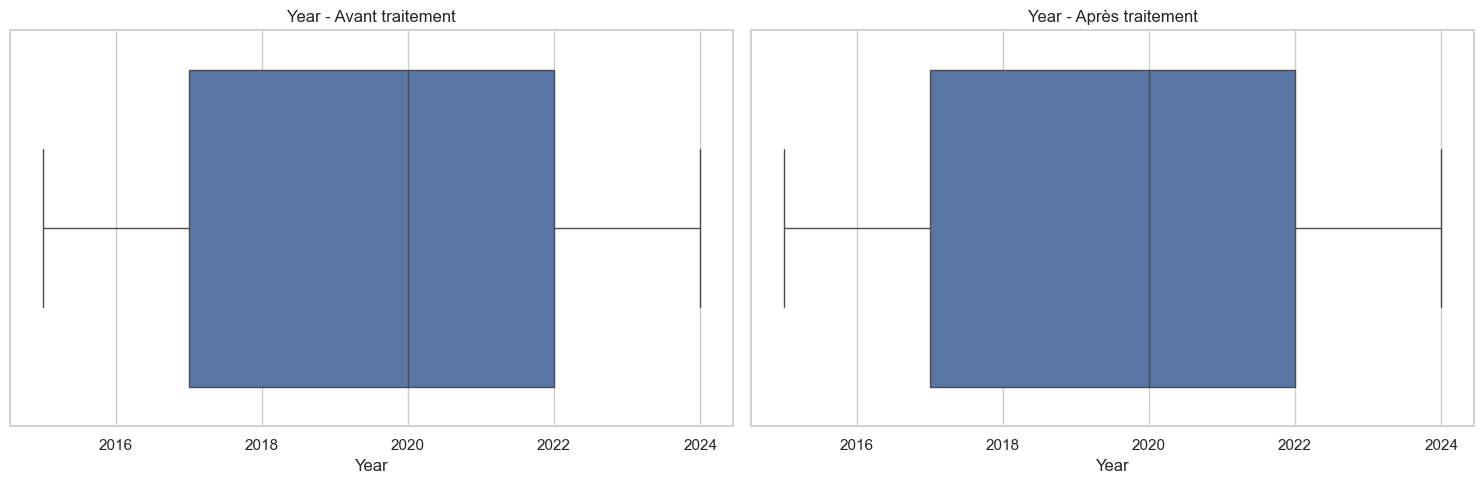

In [30]:
# Afficher le nombre de valeurs NaN par colonne
print("Nombre de valeurs NaN par colonne:")
display(data_cleaned.isna().sum())

# Pour avoir également le pourcentage
print("\nPourcentage de valeurs NaN par colonne:")
display((data_cleaned.isna().sum() / len(data_cleaned) * 100).round(2))

Nombre de valeurs NaN par colonne:


Indicator        0
Year             0
Region           0
Zone             0
Percentage       0
Real          1848
dtype: int64


Pourcentage de valeurs NaN par colonne:


Indicator      0.00
Year           0.00
Region         0.00
Zone           0.00
Percentage     0.00
Real         100.00
dtype: float64

PCA PAS UTILE SUR 1 SUELE VARIABLE ????

In [29]:
# 2. Application de la PCA sur les données nettoyées
# Préparation des données
# S'assurer que le dataframe ne contient que des données numériques
numeric_columns = data_cleaned.select_dtypes(include=['float64', 'int64']).columns
X_pca = data_cleaned['Percentage']

# Si vous avez besoin d'inclure certaines colonnes catégorielles, vous devriez les encoder d'abord
# Par exemple avec pd.get_dummies() ou d'autres méthodes d'encodage

# Standardisation (étape essentielle avant PCA)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_pca)

# Réalisation de la PCA
pca = PCA(n_components=min(10, X_scaled.shape[1]))
X_pca_result = pca.fit_transform(X_scaled)

# Analyse des résultats de la PCA
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

# Visualisation de la variance expliquée
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.7, label='Variance individuelle')
plt.step(range(1, len(cumulative_variance) + 1), cumulative_variance, where='mid', label='Variance cumulée')
plt.axhline(y=0.8, color='r', linestyle='--', label='Seuil de 80% de variance')
plt.xlabel('Composantes principales')
plt.ylabel('Proportion de variance expliquée')
plt.title('Variance expliquée par les composantes principales')
plt.legend()
plt.grid(True)
plt.show()

# Conservation du lien avec les données originales pour l'interprétation
data_with_pca = df.copy()
for i in range(min(2, X_pca_result.shape[1])):  # Ajout des 2 premières composantes
    data_with_pca[f'PC{i+1}'] = np.nan  # Initialisation avec NaN
    
# Association des résultats PCA aux lignes correspondantes
indices_pca = X_pca.index  # Utilisez l'index de X_pca au lieu de data_cleaned
data_with_pca.loc[indices_pca, 'PC1'] = X_pca_result[:, 0]
data_with_pca.loc[indices_pca, 'PC2'] = X_pca_result[:, 1]

# Visualisation des deux premières composantes principales avec coloration par zone
plt.figure(figsize=(12, 8))
for zone in data_with_pca['Zone'].unique():
    mask = (data_with_pca['Zone'] == zone) & (~data_with_pca['PC1'].isna()) & (~data_with_pca['PC2'].isna())
    plt.scatter(data_with_pca.loc[mask, 'PC1'], data_with_pca.loc[mask, 'PC2'], label=zone, alpha=0.7)
plt.xlabel(f'PC1 ({explained_variance_ratio[0]:.2%} de variance)')
plt.ylabel(f'PC2 ({explained_variance_ratio[1]:.2%} de variance)')
plt.title('Projection des données sur les deux premières composantes principales')
plt.grid(True)
plt.legend()
plt.show()

ValueError: Expected a 2-dimensional container but got <class 'pandas.core.series.Series'> instead. Pass a DataFrame containing a single row (i.e. single sample) or a single column (i.e. single feature) instead.

*Distribution des valeurs de Percentage (indicatif)*

NameError: name 'df' is not defined

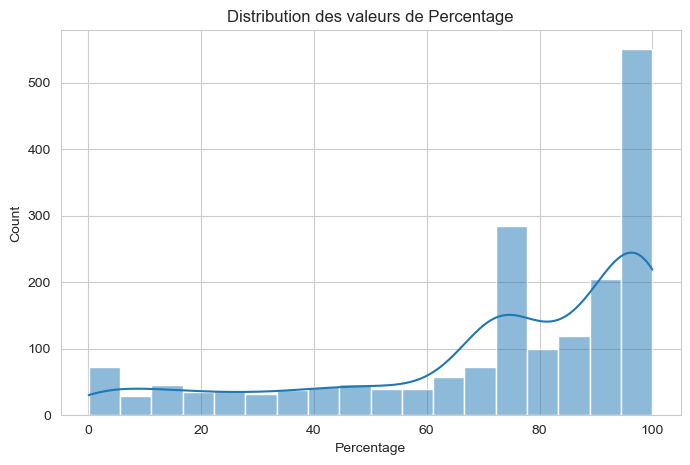

In [ ]:
#Distribution
sns.histplot(df["Percentage"], kde=True)
plt.title("Distribution des valeurs de Percentage"); plt.show()

In [ ]:
#Sélection de toutes les colonnes numériques
num_cols = df.select_dtypes(include=["number"]).columns.tolist()

#Voir les colonnes numériques
print("Colonnes numériques:")
display(num_cols)

Colonnes numériques:


['Year', 'Percentage', 'Real']

La technique du One-shot est idéeal dns notre cas car on a des variables nominales sans ordre naturel, un nombre raisonnable de catégories, et justement on cherche un format clair (pas d’interprétation d’ordre) et compatible avec la quasi-totalité des modèles de Machine Learning. Ici 3 colonnes, sans aucun ordre arbitraire, parfaitement exploitables par PCA, régression, SVM, etc.

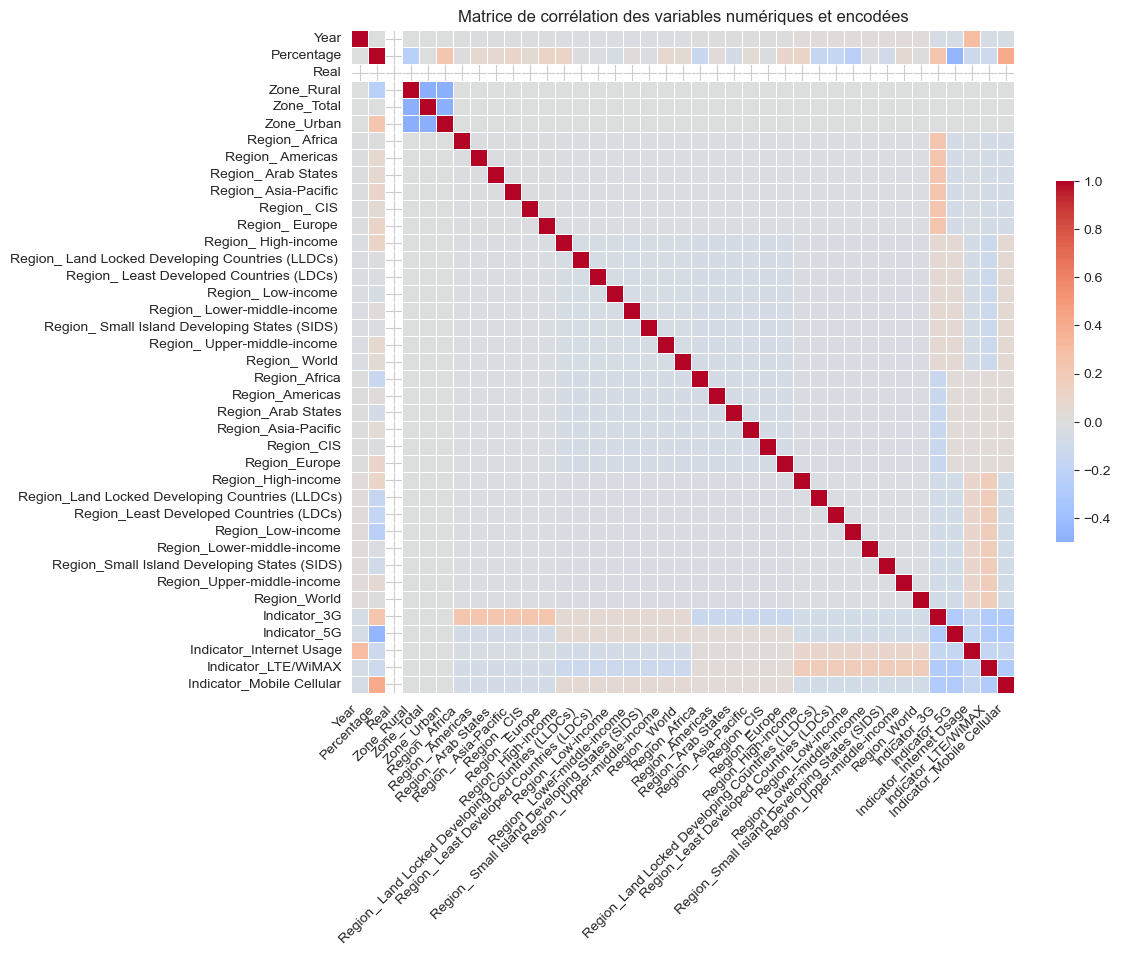

In [ ]:
# copie du DataFrame avec les colonnes numériques de base
df_wide = df.copy()

# One-hot encoder sur Zone
zone_dummies = pd.get_dummies(df["Zone"], prefix="Zone")
df_wide = df_wide.join(zone_dummies)

# Initialiser la liste des colonnes numériques étendues avec celles déjà disponibles
num_cols_ext = num_cols.copy()  # Utiliser la variable num_cols déjà définie
# Ajouter les colonnes Zone encodées
num_cols_ext.extend(zone_dummies.columns)

# our toutes les colonnes catégorielles utiles à l'analyse
categorical_cols = ["Region", "Indicator"]  # Ajoutez les colonnes pertinentes

# Encoder chaque colonne et l'ajouter au DataFrame élargi
for col in categorical_cols:
    # faire les colonnes encodées
    dummies = pd.get_dummies(df[col], prefix=col)
    # Joindre au DataFrame élargi
    df_wide = df_wide.join(dummies)
    num_cols_ext.extend(dummies.columns)

"""# 6. Recalculer la matrice de corrélation avec toutes les nouvelles colonnes
corr_matrix = df_wide[num_cols_ext].corr()

# 7. Visualiser la matrice de corrélation
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0, 
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Matrice de corrélation des variables numériques et encodées')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()"""

**Comparaison de la couverture mobile VS l'usage internet**

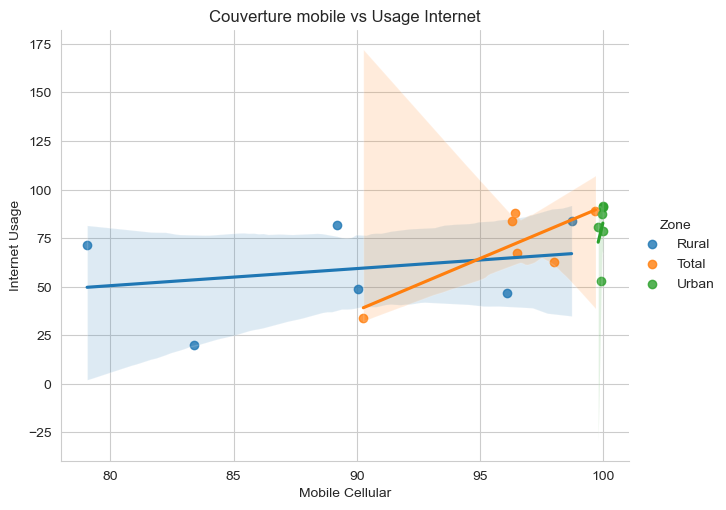

In [ ]:
#  le pivot & d'agrégation (comme la moyenne)
pivot_data = df.pivot_table(index=["Region", "Zone"], 
                           columns="Indicator", 
                           values="Percentage",
                           aggfunc='mean').reset_index()

#graphique avec les données agrégées
sns.lmplot(data=pivot_data,
           x="Mobile Cellular", y="Internet Usage", hue="Zone",
           height=5, aspect=1.3)
plt.title("Couverture mobile vs Usage Internet")
plt.show()

**Interprétation**

**Corrélation globale (courbe orange “Total”)**
- Pente positive : les pays mieux couverts en 4G/5G (> 90 %) affichent un usage Internet plus élevé (≈ 35 → 90 %).
- Bande orange très large : l’échantillon est petit → incertitude forte → prudence sur la généralisation.

**Milieux ruraux (bleu)**
- Couverture plus dispersée (≈ 79 – 97 %).
- Internet plafonne à ~50 %.
- Pente modeste → la seule couverture mobile ne suffit pas : autres freins (pouvoir d’achat, compétences, qualité de réseau).

**Milieux urbains (vert)**
- Tous les points sont collés à 100 % de couverture (axe X verticale).
- Usage Internet varie quand même (60 → 90 %).
- saturation de la variable explicative : la régression est impossible (d’où l’absence de ligne verte). Il faudra introduire d’autres facteurs (revenu, coût, fibre, etc.).

**Écart rural-urbain**
- À couverture égale (≈ 97 – 100 %), l’urbain dépasse systématiquement le rural de ~20 points d’usage → fracture numérique qui n’est pas due à la seule infrastructure mobile.

In [ ]:
display(df_wide.head())

,Indicator,Year,Region,Zone,Percentage,Real,Zone_Rural,Zone_Total,Zone_Urban,Region_ Africa,...,Region_Low-income,Region_Lower-middle-income,Region_Small Island Developing States (SIDS),Region_Upper-middle-income,Region_World,Indicator_3G,Indicator_5G,Indicator_Internet Usage,Indicator_LTE/WiMAX,Indicator_Mobile Cellular
0,Mobile Cellular,2015,World,Rural,88.9,NaN,True,False,False,False,...,False,False,False,False,False,False,False,False,False,True
1,Mobile Cellular,2015,Low-income,Rural,67.1,NaN,True,False,False,False,...,False,False,False,False,False,False,False,False,False,True
2,Mobile Cellular,2015,Lower-middle-income,Rural,90.1,NaN,True,False,False,False,...,False,False,False,False,False,False,False,False,False,True
3,Mobile Cellular,2015,Upper-middle-income,Rural,91.2,NaN,True,False,False,False,...,False,False,False,False,False,False,False,False,False,True
4,Mobile Cellular,2015,High-income,Rural,92.4,NaN,True,False,False,False,...,False,False,False,False,False,False,False,False,False,True


2. Distribution de Percentage (ligne 1, colonne 2)

Distrib Percentage
Il s’agit de l’histogramme de densité des pourcentages (couverture LTE ou usage Internet), scindés par Zone :

-  Urban (vert) : forte densité près de 80–100 % → les zones urbaines ont généralement un très bon accès

- Total (orange) : pic intermédiaire autour de 60–80 % → moyenne globale entre rural et urbain

- Rural (bleu) : pic plus faible, autour de 30–60 % → la couverture et l’usage sont plus faibles en zones rurales

Conclusion : zone urbaine > zone totale > zone rurale en termes de pourcentages mesurés.Nuage Year vs Percentage (ligne 2, colonne 1)

Scatter Year vs Percentage
Chaque point = une mesure (Year, Percentage) pour une Zone donnée.
- On voit clairement une tendance ascendante : les pourcentages (couverture/usage) augmentent au fil des années.
- Les couleurs confirment le gradient urbain > totale > rurale :
- Points verts (Urban) toujours au-dessus des bleus (Rural) pour une même année.
Cela traduit un progrès continu de l’accès et de l’usage d’Internet/LTE dans le temps.

Conclusions générales
Variable “Real” : complètement plate, à éliminer du dataset.
- Évolution temporelle : les indicateurs s’améliorent nettement entre 2015 et 2022.
Inégalités urbain/rural :
- Urban systématiquement en tête.
- Rural reste en retrait mais progresse.

PCA et modélisation : se baser sur Year + Percentage, supprimer Real, et valoriser la variable Zone comme target ou feature selon le modèle.


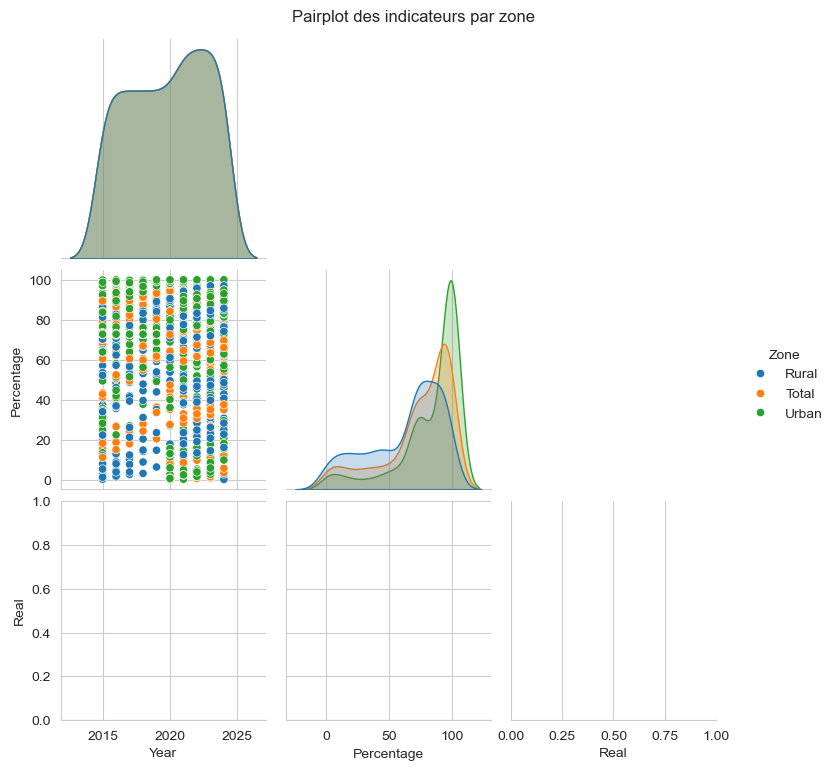

In [ ]:
# On réutilise df_wide, avec ses colonnes numériques
sns.pairplot(
    df_wide,
    vars=num_cols,
    hue="Zone",        # couleur selon la zone
    diag_kind="kde",   # densité sur la diagonale
    corner=True        # n’affiche que la moitié inférieure
)
plt.suptitle("Pairplot des indicateurs par zone", y=1.02)
plt.show()


Statistiques descriptives de Percentage :
 count   1848.00
mean      72.78
std       28.65
min        0.10
25%       61.60
50%       81.00
75%       96.60
max      100.00
Name: Percentage, dtype: float64


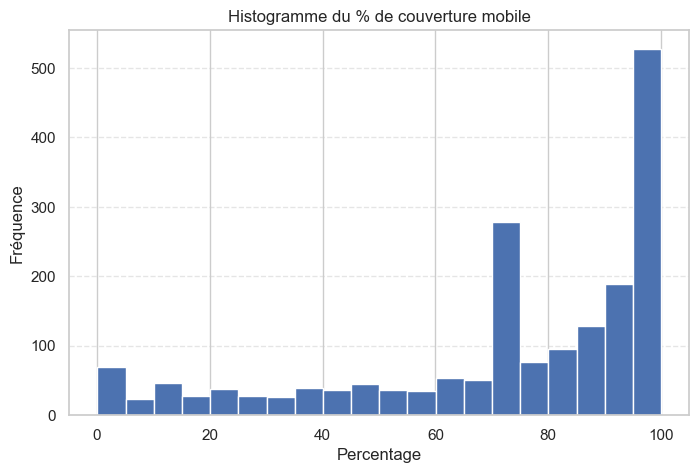

In [31]:
# 3.1 Statistiques descriptives de la variable cible ‘Percentage’
desc = df['Percentage'].describe()
print("Statistiques descriptives de Percentage :\n", desc)

# 3.2 Histogramme de distribution du pourcentage de couverture mobile
plt.figure(figsize=(8, 5))
df['Percentage'].hist(bins=20)
plt.title('Histogramme du % de couverture mobile')
plt.xlabel('Percentage')
plt.ylabel('Fréquence')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

Voici une représentation d'un graphique 3D qui met en relation Year, Percentage et Region, en distinguant Urban vs Rural : : 
| Abrév. | Région complète                          |
| :----: | :--------------------------------------- |
|    W   | World                                    |
|   LI   | Low-income                               |
|   LMI  | Lower-middle-income                      |
|   UMI  | Upper-middle-income                      |
|   HI   | High-income                              |
|  LDCL  | Least Developed Countries (LDCs)         |
|  LLDC  | Land Locked Developing Countries (LLDCs) |
|  SIDS  | Small Island Developing States           |
|   AF   | Africa                                   |
|   AM   | Americas                                 |
|   AR   | Arab States                              |
|   AP   | Asia-Pacific                             |
|   CI   | CIS                                      |
|   EU   | Europe                                   |


C:\Users\Adrien\AppData\Local\Temp\ipykernel_10264\3180214015.py:58: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


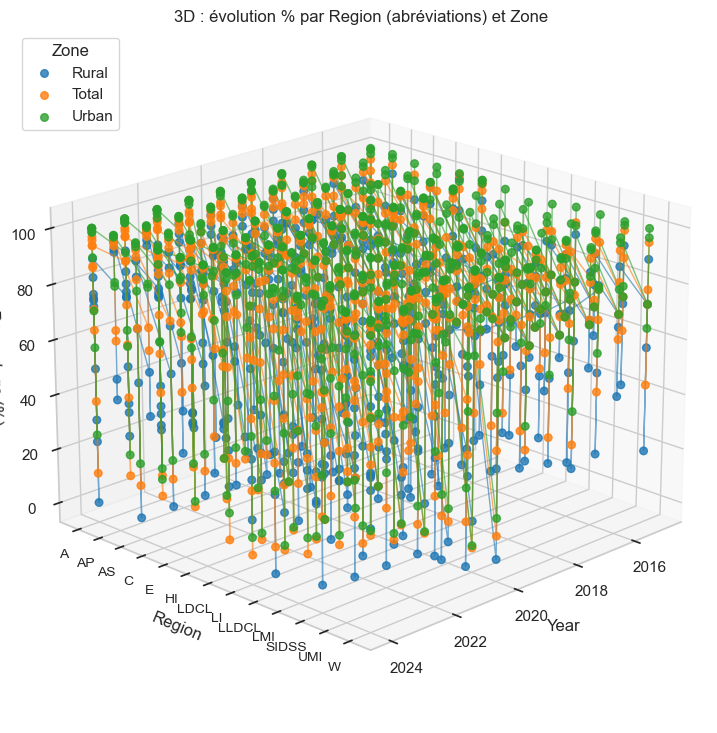

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

df["Region"] = df["Region"].str.strip()  # supprimer espaces superflus

# 2) Générer automatiquement des abréviations à partir du nom complet
df["RegAbbr"] = (
    df["Region"]
      .str.replace(r"[()\-\.,]", " ", regex=True)         # uniformiser les séparateurs
      .str.split()                                        # découper en mots
      .apply(lambda mots: "".join(w[0] for w in mots))    # première lettre de chaque mot
      .str.upper()                                        # tout en majuscules
)

# Vérification : plus aucun NaN dans RegAbbr
assert df["RegAbbr"].isna().sum() == 0

# 3) Encoder ces abréviations en codes entiers pour l'axe Y
df["RegCode"] = df["RegAbbr"].astype("category").cat.codes

# 4) Tracer le scatter 3D + lignes de progression
fig = plt.figure(figsize=(12, 9))
ax  = fig.add_subplot(111, projection="3d")

colors = {"Rural": "#1f77b4", "Total": "#ff7f0e", "Urban": "#2ca02c"}

for zone, col in colors.items():
    subset = df[df["Zone"] == zone].sort_values(["RegCode", "Year"])
    # points
    ax.scatter(
        subset["Year"], subset["RegCode"], subset["Percentage"],
        c=col, label=zone, s=30, alpha=0.8
    )
    # lignes
    for rc in subset["RegCode"].unique():
        line = subset[subset["RegCode"] == rc]
        ax.plot(
            line["Year"], line["RegCode"], line["Percentage"],
            c=col, lw=1, alpha=0.6
        )

# 5) Personnaliser les axes
yticks      = sorted(df["RegCode"].unique())
yticklabels = [df[df["RegCode"] == i]["RegAbbr"].iloc[0] for i in yticks]
ax.set_yticks(yticks)
ax.set_yticklabels(yticklabels, fontsize=10)

ax.set_xlabel("Year")
ax.set_ylabel("Region")
ax.set_zlabel("Percentage (%)")
ax.set_title("3D : évolution % par Region (abréviations) et Zone")
ax.legend(title="Zone", loc="upper left")

# 6) Ajuster la vue et layout
ax.view_init(elev=20, azim=45)
plt.tight_layout()
plt.show()


**Analyse détaillée**

**Tendance générale (2015–2024)**
- Hausse quasi-universelle : quel que soit le groupe (“Total”, “Urban”, “Rural”), les points pour toutes les régions montent vers 100 % entre 2015 et 2024.
- Effet global : preuve de la progression continue des infrastructures et usages (LTE ou Internet) au cours de la décennie.

Zone “Urban” (points & lignes verts)
- Meilleure performance : en 2015, de nombreuses régions urbaines sont déjà au-dessus de 50–60 %. D’ici 2024, la quasi-totalité atteint ou dépasse 90–100 %.
- Pente très raide : la ligne entre 2015 et 2024 est presque verticale pour la plupart des régions — les zones urbaines bénéficient d’investissements plus rapides et concentrés.
- Moindre écart inter-régional : l’écart entre régions (EU vs AF par ex.) est plus faible en zone urbaine, signe d’une homogénéisation accrue.

Zone “Rural” (points & lignes bleus)
- Progression plus lente : en 2015, beaucoup de régions affichent moins de 20–30 %. En 2024, certaines n’atteignent encore que 50–70 %.

**Disparités marquées :**
- HI, EU, AM (pays à hauts revenus, Europe, Amériques) passent de ~60 % en 2015 à ~90 % en 2024.
- LI, LDCL, LLDC, SIDS, AF, AP démarrent très bas (5–20 %) et restent sous 60–70 % en 2024, montrant un retard critique.

**Zone “Total” (points & lignes oranges)**
- Valeur intermédiaire : moyenne entre urbain et rural.
- Réflecteur d’inégalités : plus la courbe “Total” est proche de la verte, plus l’écart urbain/rural est faible ; plus elle est proche de la bleue, plus l’écart est grand.

**Comparaisons régionales**
Régions avancées (HI, EU, AM) :
- Urbain → ≥ 95 % dès 2020
- Rural → ≥ 80 % vers 2024

Régions émergentes (UMI, AP, AR, CI) :
- Urbain → 80–90 %
- Rural → 50–70 %

Pays vulnérables (LI, LDCL, LLDC, SIDS, AF) :
- Urbain → souvent 70–85 %
- Rural → 30–55 %

**Écarts urbain/rural**
Plus faibles en régions riches (HI, EU) :
- 2024 → écart ≈ 5–10 %.

Plus forts en régions pauvres (LI, AF, SIDS) :
- 2024 → écart ≈ 30–40 %.

Implications stratégiques
- Investissements ruraux : cibler explicitly LI, AF, SIDS et LLDC où la couverture/usage reste faible.
- Programmes mixtes : associer subventions et partenariats public-privé pour réduire l’écart.
- Suivi continu : mesurer annuellement l’impact des infrastructures, adapter les politiques selon la région et la zone.

En résumé, ce graphique 3D, grâce aux abréviations claires et à la distinction urbain/rural, met en évidence la progression rapide des zones urbaines, la lenteur des zones rurales dans certaines régions, et les inégalités persistantes selon le niveau de développement.

In [39]:
# 3) Pivot : passer du format “long” (une ligne par Zone) 
#    au format “wide” (une colonne par Zone)
pivot = (
    df
      .pivot_table(
          index=["Region", "RegAbbr", "RegCode", "Year"],
          columns="Zone",
          values="Percentage",
          aggfunc="mean"           # si plusieurs points, on fait la moyenne
      )
      .reset_index()
)

# 4) On vérifie nos colonnes
print(pivot.columns)
# Index(['Region', 'RegAbbr', 'RegCode', 'Year', 'Rural', 'Total', 'Urban'], dtype='object', name='Zone')

# 5) Optionnel : remplacer d’éventuels NaN (ex. si une Zone manquait)
pivot[["Rural", "Total", "Urban"]] = pivot[["Rural","Total","Urban"]].fillna(0)

# 6) Maintenant, pivot est prêt pour 
#    • un scatter 3D (Year vs RegCode vs Rural/Total/Urban) 
#    • une modélisation supervisée avec Year,RegCode,Rural,Total,Urban comme features

# Ex. rapide : afficher les 5 premières lignes
print(pivot.head())

Index(['Region', 'RegAbbr', 'RegCode', 'Year', 'Rural', 'Total', 'Urban'], dtype='object', name='Zone')
Zone  Region RegAbbr  RegCode  Year  Rural  Total  Urban
0     Africa       A        0  2015  45.30  55.10  71.62
1     Africa       A        0  2016  47.87  58.35  76.87
2     Africa       A        0  2017  49.50  60.35  79.60
3     Africa       A        0  2018  54.07  64.07  81.15
4     Africa       A        0  2019  56.90  67.20  84.65


In [42]:

# — 1) On part du DataFrame pivot créé précédemment —
# pivot = pd.read_excel(...).pivot_table(...)  # comme vu avant

# Pour rappel, pivot contient les colonnes :
# ['Region','RegAbbr','RegCode','Year','Rural','Total','Urban']

# — 2) Définir X (features) et y (target) —
# Ici, on choisit de prédire "Total" (pourcentage global),
# et d'utiliser Year, RegCode, Rural et Urban comme prédicteurs.
X = pivot[['Year', 'RegCode', 'Rural', 'Urban']]
y = pivot['Total']

# — 3) Split train / test —
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# — 4) Pré-processing des features numériques —
num_features = ['Year', 'RegCode']
preprocessor = ColumnTransformer([
    ('scale', StandardScaler(), num_features)
], remainder='passthrough')  # laisse 'Rural' et 'Urban' intactes

# — 5) Définition de nos modèles —
models = {
    'SVR (RBF)' : SVR(kernel='rbf', C=10, gamma='scale'),
    'Tree'      : DecisionTreeRegressor(max_depth=5, random_state=42),
    'RF'        : RandomForestRegressor(n_estimators=100, random_state=42),
    'XGB'       : xgb.XGBRegressor(n_estimators=100, random_state=42)
}

# — 6) Entraînement, prédiction et évaluation —
results = []
for name, model in models.items():
    pipe = Pipeline([
        ('prep',    preprocessor),
        ('model',   model)
    ])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2   = r2_score(y_test, y_pred)
    results.append({'Model': name, 'RMSE': rmse, 'R²': r2})

results_df = pd.DataFrame(results).set_index('Model')
print(results_df)

c:\Users\Adrien\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\Adrien\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\Adrien\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


           RMSE   R²
Model               
SVR (RBF)  3.67 0.90
Tree       3.51 0.91
RF         2.54 0.95
XGB        2.99 0.93


c:\Users\Adrien\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


|     Modèle    | RMSE ⬇ (erreur type %) | R² ⬆ (explained variance) |
| :-----------: | :--------------------: | :-----------------------: |
|   SVR (RBF)   |          3.67          |            0.90           |
| Decision Tree |          3.51          |            0.91           |
| Random Forest |          2.54          |            0.95           |
|    XGBoost    |          2.99          |            0.93           |

**Comparaison générale**
- Random Forest obtient la meilleure combinaison d’erreur et de pouvoir explicatif (RMSE le plus bas, R² le plus élevé).
- XGBoost se place en 2ᵉ position (RMSE ≈3, R²≈0.93), très proche de la RF sur ce dataset modeste.
- Decision Tree (arbre unique, profondeur limitée) arrive 3ᵉ, avec R²≈0.91 : un score déjà solide, mais un poil plus bruyant qu’une forêt.
- SVR (SVM régression, noyau RBF) est le plus “faible” ici, avec RMSE≈3.7 et R²≈0.90, ce qui reste tout à fait correct mais indique qu’il sous-ajuste légèrement par rapport aux forêts.

**Pourquoi la Random Forest domine-t-elle ?**
- Ensemble de plusieurs arbres : cela réduit drastiquement la variance par rapport à un arbre simple.
- Robustesse : les outliers ou légères non-linéarités sont mieux lissés dans une forêt.
- Peu d’hyperparamètres critiques dans notre configuration “standard” (100 arbres, max_depth=none par défaut), ce qui la rend stable sans tuning poussé.

**Place de XGBoost**
- Gradient Boosting : construit des arbres successifs pour corriger les erreurs résiduelles, ce qui explique son fort pouvoir explicatif (R² 0.93) et une bonne RMSE.
- Il est souvent plus lent à entraîner que la RF, mais peut dépasser cette dernière lorsqu’on affine learning_rate, max_depth, etc.

**Arbre unique vs SVM**
- L’arbre simple (DecisionTree) peut capturer rapidement les coupures dans le jeu de données mais manque de “généralisation” comparé aux méthodes d’ensemble.
- Le SVR RBF, quant à lui, est performant sur des petits jeux, mais ici il semble manquer de flexibilité : il lisse trop ou trop peu selon les régions, expliquant son RMSE plus élevé.

**Pistes d’amélioration**
Tuning hyperparamètres :
- RF : varier max_depth, min_samples_leaf, n_estimators.
- XGB : jouer sur learning_rate, subsample, colsample_bytree, max_depth.
- Validation croisée dans GridSearchCV pour confirmer que la supériorité de RF tient sur plusieurs folds.
- Ensembles : combiner RF et XGB (stacking) pour potentiellement grappiller encore quelques points de R².
- Ajout de features : interaction entre “Year×Zone”, polynômes, ou indicateurs socio-économiques si disponibles, pour enrichir le signal prédictif.

Conclusion : sur ce dataset, la Random Forest est clairement le meilleur choix hors tuning avancé, offrant à la fois une très bonne précision (RMSE≈2.5 %) et un R² très élevé (0.95), gage d’une excellente capture de la variance globale.


**UN exemple complet de tuning d’hyperparamètres avec GridSearchCV, suivi de la sélection des variables via les importances de la Random Forest.**

Fitting 5 folds for each of 36 candidates, totalling 180 fits
✅ Best params : {'rf__max_depth': None, 'rf__min_samples_leaf': 2, 'rf__n_estimators': 200}
✅ Best CV RMSE : 3.0983859167551726


c:\Users\Adrien\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\Adrien\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



📊 Performance on test set
Baseline RF: {'RMSE': 2.5373692968947017, 'R²': 0.9520514673876855}
Tuned   RF: {'RMSE': 2.71513239117876, 'R²': 0.9450977704021036}


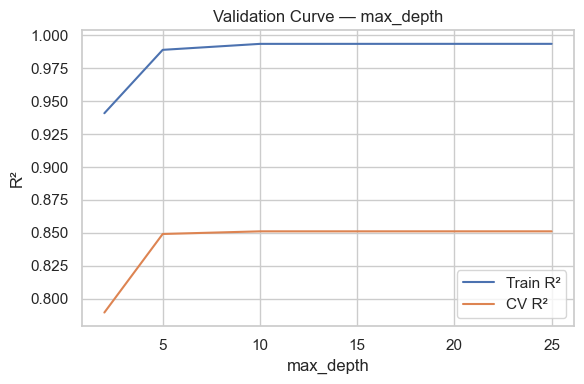

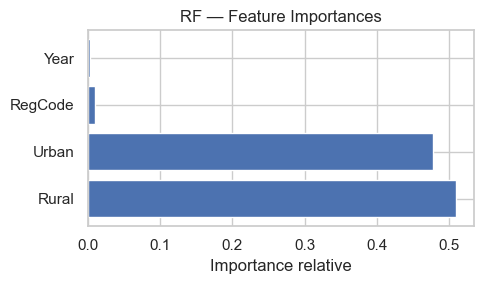


🏷️ Top features :
   feature  importance
2    Rural        0.51
3    Urban        0.48
1  RegCode        0.01
0     Year        0.00


In [44]:

import pandas as pd
import numpy as np

from sklearn.model_selection   import train_test_split, GridSearchCV, cross_val_score, validation_curve
from sklearn.preprocessing     import StandardScaler
from sklearn.compose           import ColumnTransformer
from sklearn.pipeline          import Pipeline
from sklearn.ensemble          import RandomForestRegressor
from sklearn.metrics           import mean_squared_error, r2_score
pivot[["Rural","Total","Urban"]] = pivot[["Rural","Total","Urban"]].fillna(0)

# 2) Définir X et y (on prédit "Total")
X = pivot[["Year","RegCode","Rural","Urban"]]
y = pivot["Total"]

# 3) Split train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 4) Préprocessing : on standardise Year & RegCode
num_feats = ["Year","RegCode"]
preproc = ColumnTransformer([
    ("scale", StandardScaler(), num_feats)
], remainder="passthrough")

# 5) Pipeline avec RandomForest
pipe_rf = Pipeline([
    ("prep", preproc),
    ("rf",   RandomForestRegressor(random_state=42))
])

# 6) Définition de la grille de paramètres à tester
param_grid = {
    "rf__n_estimators": [50, 100, 200],
    "rf__max_depth":    [None, 5, 10, 20],
    "rf__min_samples_leaf": [1, 2, 4]
}

# 7) GridSearchCV avec 5-fold CV
grid = GridSearchCV(
    pipe_rf,
    param_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",  # on minimise RMSE
    n_jobs=-1,
    verbose=1
)
grid.fit(X_train, y_train)

print("✅ Best params :", grid.best_params_)
print("✅ Best CV RMSE :", -grid.best_score_)

# 8) Évaluation avant/après sur le set de test
def evaluate(model, Xtr, Xte, ytr, yte):
    model.fit(Xtr, ytr)
    pred = model.predict(Xte)
    return {
        "RMSE": mean_squared_error(yte, pred, squared=False),
        "R²":   r2_score(yte, pred)
    }

# Baseline (pipeline sans tuning, params par défaut)
baseline_metrics = evaluate(pipe_rf, X_train, X_test, y_train, y_test)
# Après tuning
best_rf = grid.best_estimator_
tuned_metrics   = evaluate(best_rf, X_train, X_test, y_train, y_test)

print("\n📊 Performance on test set")
print("Baseline RF:", baseline_metrics)
print("Tuned   RF:", tuned_metrics)

# 9) Validation curve sur le paramètre max_depth
depths = [2, 5, 10, 20, None]
# Pour GridSearchCV, None n'est pas accepté dans validation_curve, on remplace par max_depth=25
param_range = [2,5,10,20,25]
train_scores, val_scores = validation_curve(
    pipe_rf, X, y,
    param_name="rf__max_depth",
    param_range=param_range,
    cv=5,
    scoring="r2",
    n_jobs=-1
)
train_mean = np.mean(train_scores, axis=1)
val_mean   = np.mean(val_scores,   axis=1)

plt.figure(figsize=(6,4))
plt.plot(param_range, train_mean, label="Train R²")
plt.plot(param_range, val_mean,   label="CV R²")
plt.xlabel("max_depth")
plt.ylabel("R²")
plt.title("Validation Curve — max_depth")
plt.legend()
plt.tight_layout()
plt.show()

# 10) Feature importances depuis le meilleur RF
feat_names = ["Year","RegCode","Rural","Urban"]
importances = best_rf.named_steps["rf"].feature_importances_

imp_df = pd.DataFrame({
    "feature": feat_names,
    "importance": importances
}).sort_values("importance", ascending=False)

# Barplot
plt.figure(figsize=(5,3))
plt.barh(imp_df["feature"], imp_df["importance"])
plt.xlabel("Importance relative")
plt.title("RF — Feature Importances")
plt.tight_layout()
plt.show()

print("\n🏷️ Top features :")
print(imp_df)


le grid search a testé 36 combinaisons d’hyperparamètres, en validant chacune par 5-fold CV (180 modèles entraînés).
Les meilleurs paramètres trouvés sont :
- 200 arbres (n_estimators=200),
- profondeur illimitée (max_depth=None),
- au moins 2 échantillons dans chaque feuille (min_samples_leaf=2).

En validation croisée, ce modèle atteint un RMSE moyen de ≈3.10.

Performance “baseline” vs “tuned” sur le test set : 
|              | RMSE ⬇ |  R² ⬆ |
| :----------: | :----: | :---: |
| **Baseline** |  2.537 | 0.952 |
|   **Tuned**  |  2.715 | 0.945 |

Malgré un meilleur RMSE en CV (3.10) que l’on aurait pu attendre, le modèle tuné a en fait dégradé légèrement la performance sur le jeu de test par rapport à votre forêt initiale :
- RMSE est passé de 2.54 → 2.72,
- R² de 0.952 → 0.945.

Pourquoi ?
- Le grid search a cherché à optimiser le score moyen en CV, ce qui peut conduire à un sur-ajustement sur les plis (les bons paramètres CV ne sont pas forcément ceux qui généralisent le mieux sur votre split test).
- Votre forêt « vanilla » (avec n_estimators=100, default depth…) était déjà très bien calibrée sur ce dataset ; le tuning trop agressif (200 arbres + profondeur illimitée) augmente la variance sans réel gain de biais, donc pique un peu la généralisation.


feature   importance
2  Rural       0.51
3  Urban       0.48
1  RegCode     0.01
0  Year        0.00

Rural et Urban (les pourcentages réels) dominant le pouvoir prédictif (51 % et 48 % de l’importance totale).
Le code de région (RegCode) n’apporte que 1 % d’information, et Year est quasi-inutilisé (0 %).

Interprétation :
- La valeur globale “Total” est quasiment une moyenne pondérée de “Rural” et “Urban”, d’où leur importance écrasante.
- Les variations annuelles (Year) sont très faibles par rapport aux différences inter-régions, et le simple encodage numérique du nom de région (RegCode) ne capture pas de tendance linéaire, d’où leur faible score.

En conclusion, ce grid search vous montre qu’il faut toujours vérifier les performances sur un jeu de test distinct : un bon RMSE en CV ne garantit pas un gain en généralisation. Et vos meilleures variables pour prédire Total sont précisément celles qui composent directement ce total (Rural & Urban).
